In [37]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
import matplotlib.pyplot as plt

In [38]:
# Define a Node class
class Node:
    def __init__(self, inputs = []):
        self.inputs = inputs
        self.outputs= []
    
        for n in self.inputs:
            n.outputs.append(self)
    
        self.value = None
        self.gradients = {}
    # Key: value 
    #inputs to this node: partials of this node

    def forward(self):
        raise NotImplemented
        
    def backward(self):
        raise NotImplemented

In [39]:
# Define a Input class
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

In [40]:
#Define the add class
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

In [41]:
#Define the linear class
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [42]:
#Define the sigmoid class
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])

    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self] 
            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [43]:
#Using the mse as the loss function and define the mse class
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])

    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [44]:
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()

In [45]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


In [46]:
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [47]:
# Loading data
data = load_boston()
X_ = data['data']
y_ = data['target']

In [48]:
# Normalizing data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

In [49]:
#Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

In [50]:
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [51]:
epochs = 5000
losses = []

In [52]:
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size
graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]
print("Total number of examples = {}".format(m))

Total number of examples = 506


In [53]:
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph)

        # Step 3
        rate = 1e-2    
        sgd_update(trainables, rate)
        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 151.877
Epoch: 101, Loss: 6.674
Epoch: 201, Loss: 4.439
Epoch: 301, Loss: 4.421
Epoch: 401, Loss: 4.814
Epoch: 501, Loss: 3.898
Epoch: 601, Loss: 3.833
Epoch: 701, Loss: 4.835
Epoch: 801, Loss: 4.032
Epoch: 901, Loss: 3.921
Epoch: 1001, Loss: 2.949
Epoch: 1101, Loss: 3.498
Epoch: 1201, Loss: 3.385
Epoch: 1301, Loss: 3.343
Epoch: 1401, Loss: 3.655
Epoch: 1501, Loss: 3.621
Epoch: 1601, Loss: 3.487
Epoch: 1701, Loss: 3.031
Epoch: 1801, Loss: 3.167
Epoch: 1901, Loss: 3.202
Epoch: 2001, Loss: 2.881
Epoch: 2101, Loss: 2.911
Epoch: 2201, Loss: 2.931
Epoch: 2301, Loss: 2.922
Epoch: 2401, Loss: 3.278
Epoch: 2501, Loss: 2.990
Epoch: 2601, Loss: 3.543
Epoch: 2701, Loss: 3.323
Epoch: 2801, Loss: 3.200
Epoch: 2901, Loss: 3.016
Epoch: 3001, Loss: 2.965
Epoch: 3101, Loss: 3.331
Epoch: 3201, Loss: 2.734
Epoch: 3301, Loss: 3.226
Epoch: 3401, Loss: 2.948
Epoch: 3501, Loss: 2.743
Epoch: 3601, Loss: 3.401
Epoch: 3701, Loss: 3.216
Epoch: 3801, Loss: 2.866
Epoch: 3901, Loss: 2.719
Epoch: 400

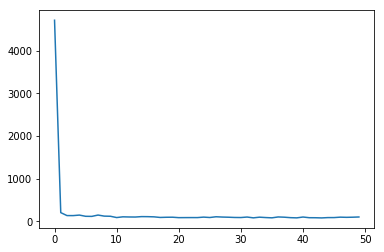

In [54]:
plt.plot(range(len(losses)), losses)